In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import dask
from dask.diagnostics import ProgressBar
import os

In [2]:
tmp_data_path = '../MA_data/data/tmp'
data_path = '../MA_data/data'

s_year = 1997
e_year = 2020


# Load data

In [3]:
sdc_tnic = pd.read_pickle(tmp_data_path+f"/sdc_tnic_{s_year}_{e_year}")

In [4]:
tnic = pd.read_pickle(tmp_data_path+f"/tnic2_{s_year-1}_{e_year-1}")


In [5]:
with open(tmp_data_path+f"/tnic_info_3_pairs_{s_year-1}_{e_year-1}", 'rb') as f:
    gvkey_lsts, key_ind_maps , ind_key_maps = pickle.load(f)

In [6]:
fin_var = pd.read_pickle(f'{tmp_data_path}/fv_raw_{s_year-1}_{e_year}.pickle')

# Q: plot the wave

In [24]:

count = []
for y in range(1997, 2020+1):
    count.append(sdc_tnic[sdc_tnic.YEAR == y].shape[0])

In [28]:
count

[804,
 851,
 817,
 685,
 603,
 486,
 475,
 440,
 437,
 377,
 393,
 293,
 293,
 271,
 248,
 296,
 284,
 303,
 296,
 266,
 240,
 203,
 176,
 124]

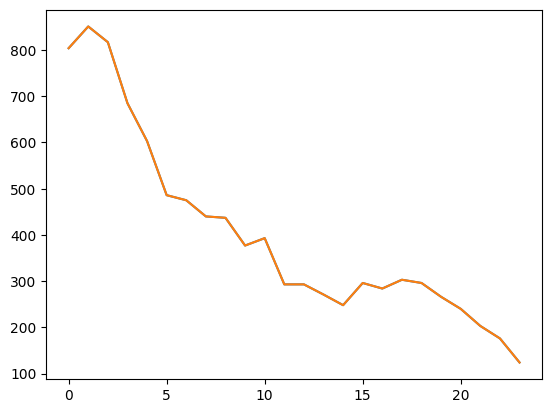

In [27]:
plt.plot(count)
plt.show()

# Q: how infrequent MA is?


In [19]:

all_gvkeys = sdc_tnic.AS_GVKEY.values.tolist() + sdc_tnic.AP_GVKEY.values.tolist() + sdc_tnic.TS_GVKEY.values.tolist() + sdc_tnic.TP_GVKEY.values.tolist()
all_gvkeys = set(all_gvkeys)


In [23]:
sdc_tnic.shape[0] / (len(all_gvkeys))

0.593500430028259

In [21]:
sdc_tnic.shape[0]

9661

# Q: What kind of firms are most likely to be acquirer
- using statistics based method



In [7]:
sdc_tnic.columns

Index(['ACU', 'ASIC2', 'ABL', 'ANL', 'APUBC', 'AUP', 'AUPSIC', 'AUPBL',
       'AUPNAMES', 'AUPPUB', 'BLOCK', 'CREEP', 'DA', 'DE', 'STATC', 'SYNOP',
       'VAL', 'PCTACQ', 'PSOUGHTOWN', 'PSOUGHT', 'PHDA', 'PCTOWN', 'PSOUGHTT',
       'PRIVATIZATION', 'DEAL_NO', 'TCU', 'TSIC2', 'TBL', 'TNL', 'TPUBC',
       'TUP', 'TUPSIC', 'TUPBL', 'TUPNAMES', 'TUPPUB', 'SIC_A', 'SIC_T',
       'YEAR', 'AS_PERMNO', 'AP_PERMNO', 'TS_PERMNO', 'TP_PERMNO', 'AS_GVKEY',
       'AP_GVKEY', 'TS_GVKEY', 'TP_GVKEY', 'GVKEY_STATUS', 'MA_TYPE', 'AGVKEY',
       'TGVKEY'],
      dtype='object')

In [8]:
AS_freq = pd.DataFrame(sdc_tnic.AS_GVKEY.value_counts()).reset_index(drop=False)

In [9]:
AP_freq = pd.DataFrame(sdc_tnic.AP_GVKEY.value_counts()).reset_index(drop=False)

In [10]:
AS_freq

,index,AS_GVKEY
0,11856,33
1,6008,24
2,6266,23
3,12142,23
4,6268,22
...,...,...
3397,184688,1
3398,29824,1
3399,13053,1
3400,7273,1


In [13]:
def plot_array(arr):
    plt.plot(arr)
    ax = plt.gca()
    #ax.set_xlim([-1, 600])
    plt.show()


first observation:

- Acquirer is more "concentrated" than target

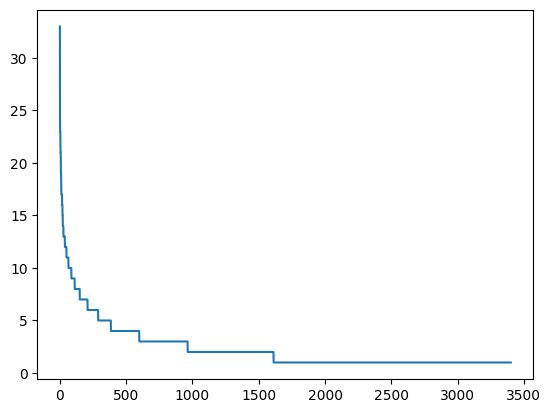

In [14]:
plot_array(np.sort(AS_freq['AS_GVKEY'].values)[::-1])

In [18]:
print(np.sort(AS_freq['AS_GVKEY'].values).mean(), np.median(np.sort(AS_freq['AS_GVKEY'].values)))

2.3821281599059376 1.0


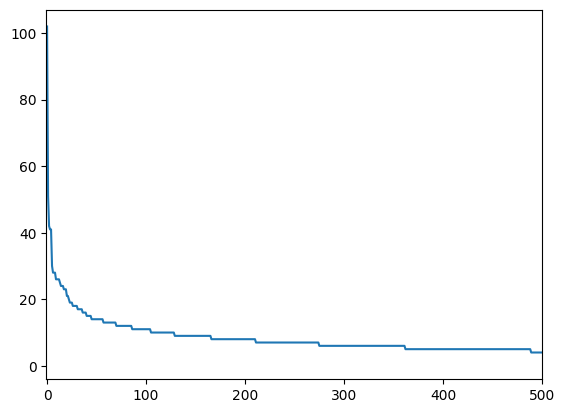

In [45]:
plot_array(np.sort(AP_freq['AP_GVKEY'].values)[::-1])

If I choose 4 as thres like Yan. did
- shrink total acquirer size down to about **600**

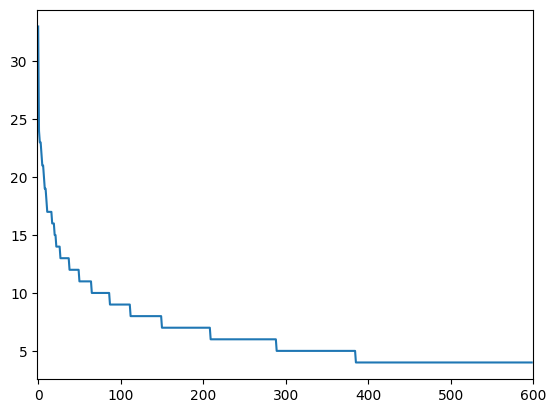

In [49]:
plot_array(np.sort(AS_freq[AS_freq.AS_GVKEY >= 4]['AS_GVKEY'].values)[::-1]) # 

How many MA events was covered by these 600 "major" acquirers?

In [98]:
for deal_thres in range(1, 5+1):
    AS_major_lst = AS_freq[AS_freq.AS_GVKEY >= deal_thres]['index'].unique().tolist()
    print("total number of major acquirer: ", len(AS_major_lst), "if threshold is ", deal_thres)
    print(sdc_tnic[(sdc_tnic['AS_GVKEY'].isin(AS_major_lst))|(sdc_tnic['AP_GVKEY'].isin(AS_major_lst))].shape[0]/sdc_tnic.shape[0], f"of all {sdc_tnic.shape[0]} MA events ({sdc_tnic[(sdc_tnic['AS_GVKEY'].isin(AS_major_lst))|(sdc_tnic['AP_GVKEY'].isin(AS_major_lst))].shape[0]}) are triggered by those acquirer")



total number of major acquirer:  3402 if threshold is  1
0.9708104751060966 of all 9661 MA events (9379) are triggered by those acquirer
total number of major acquirer:  1612 if threshold is  2
0.7678294172445916 of all 9661 MA events (7418) are triggered by those acquirer
total number of major acquirer:  964 if threshold is  3
0.619294068936963 of all 9661 MA events (5983) are triggered by those acquirer
total number of major acquirer:  599 if threshold is  4
0.49435876203291584 of all 9661 MA events (4776) are triggered by those acquirer
total number of major acquirer:  385 if threshold is  5
0.39105682641548495 of all 9661 MA events (3778) are triggered by those acquirer


# Q: How about only consider parent firms(for acquirer)

- If unable to find parent firms. Then use self
- this may shrink the size of acquirer


- no need, useless

## Create a acquirer Self-Parent mapping table
- the map table should be time sensitive (may be traded to another firm...)
- by manually checking, most P of S of acquirer is S itself. So I won't expect this helps a lot

In [65]:
def create_map(df):

    acq_SP_maps = {}

    for y in range(s_year, e_year+1): # sdc time
        acq_SP_maps[y] = {}
    count_same = 0
    count_all = 0
    for _, row in df.iterrows():
        if pd.notna(row.AS_GVKEY) & pd.notna(row.AP_GVKEY):
            if pd.notna(row.AS_GVKEY) == pd.notna(row.AP_GVKEY):
                count_same += 1
            acq_SP_maps[row.YEAR][row.AS_GVKEY] = row.AP_GVKEY
            count_all += 1
    print(f"{(count_same/count_all)*100}% of the acquirer, their parent firm are themselves")
    return acq_SP_maps

In [66]:
A_SP_maps = create_map(sdc_tnic)

100.0% of the acquirer, their parent firm are themselves


# Q: do Acquirer and Target has high TNIC similarity in absolute value?

- from absolute value, seems no. 37% of MA events are generated by completely different firm-pair with 0 tnic similarity.
    - TNIC is only about horizontal MA deal (Product Synergy)
    - What is the distribution of TNIC similarity values?


In [288]:
# merge tnic and sdc
tnic_year_plus1 = tnic.copy()
tnic_year_plus1["year"] = tnic_year_plus1["year"]+1
tnic_sdc_merge = sdc_tnic.merge(tnic_year_plus1, left_on = ["AGVKEY", "TGVKEY" , "YEAR"], right_on = ["gvkey1", "gvkey2", "year"], how = "left")



In [289]:
tnic_sdc_merge = tnic_sdc_merge.drop(['year', 'gvkey1', 'gvkey2'], axis=1)

ok. So a lot of MA happens between firm pair has so small similarity that even can be ignored (so different)

How about the major acquirer?

In [124]:
for deal_thres in range(1, 5+1):
    AS_major_lst = AS_freq[AS_freq.AS_GVKEY >= deal_thres]['index'].unique().tolist()
    print("total number of major acquirer: ", len(AS_major_lst), "if threshold is ", deal_thres)
    print("completely different firm pair portion = ", tnic_sdc_merge[(tnic_sdc_merge['AGVKEY'].isin(AS_major_lst))].score.isna().sum()/tnic_sdc_merge.shape[0])
    print("tnic score median = ", tnic_sdc_merge[(tnic_sdc_merge['AGVKEY'].isin(AS_major_lst))].score.median())
    print("tnic score max = ", tnic_sdc_merge[(tnic_sdc_merge['AGVKEY'].isin(AS_major_lst))].score.max())
    print("tnic score mean = ", tnic_sdc_merge[(tnic_sdc_merge['AGVKEY'].isin(AS_major_lst))].score.mean(), "\n")
    
 


total number of major acquirer:  3402 if threshold is  1
completely different firm pair portion =  0.3723217058275541
tnic score median =  0.0822
tnic score max =  0.8662
tnic score mean =  0.10408033269797262 

total number of major acquirer:  1612 if threshold is  2
completely different firm pair portion =  0.2956215712659145
tnic score median =  0.0814
tnic score max =  0.8662
tnic score mean =  0.10182917496129175 

total number of major acquirer:  964 if threshold is  3
completely different firm pair portion =  0.24138287961908705
tnic score median =  0.0813
tnic score max =  0.8557
tnic score mean =  0.09971385172798217 

total number of major acquirer:  599 if threshold is  4
completely different firm pair portion =  0.1923196356484836
tnic score median =  0.0804
tnic score max =  0.8476
tnic score mean =  0.099511706629055 

total number of major acquirer:  385 if threshold is  5
completely different firm pair portion =  0.1548493944726219
tnic score median =  0.0775
tnic score

Only consider Major Acquirer :
- won't help increase TNIC similarities absolute value.
- decrese the portion of "completely differnt firm pairs"



Compare with TNIC distribution
+ 0.2 is already very rare...(about 3% of peers)

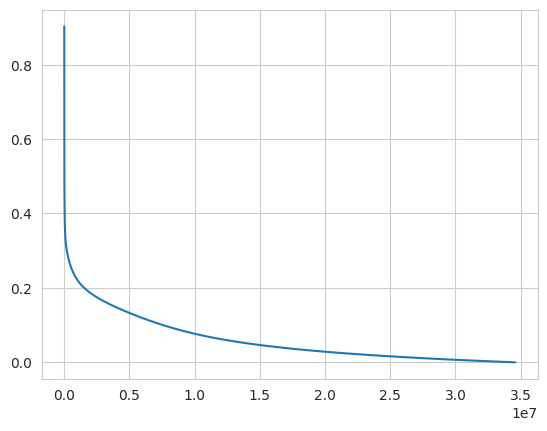

In [326]:
plt.plot(np.sort(tnic.score.values)[::-1])
ax = plt.gca()
#ax.set_xlim([-1, 300])
plt.show()

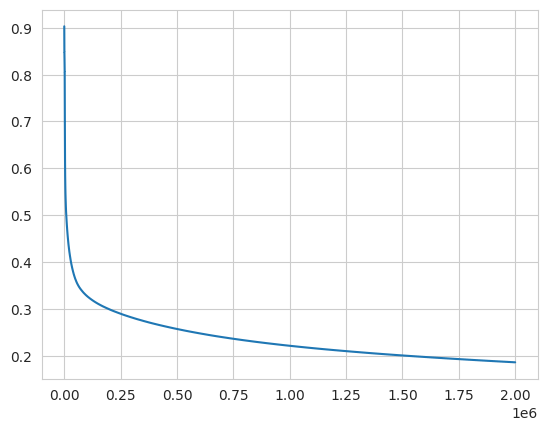

In [308]:
plt.plot(np.sort(tnic.score.values)[::-1][:1000000])
ax = plt.gca()
#ax.set_xlim([-1, 300])
plt.show()

## How about the rank? is the target always sitting in top peers of acquirer?

- kind of: the plot is an exponential like plot
    - in about half of the deal (4500), the target is rank as acquirer's peer below 100 top peer


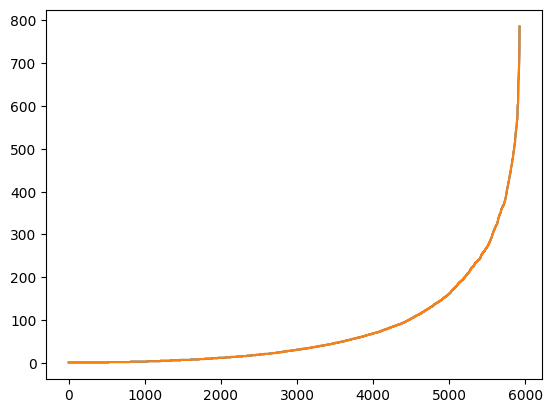

In [283]:

plt.plot(np.sort(tnic_sdc_merge['rank'].values))
plt.show()

# Q: do peer of acquirer acquire peer of target later? (like my design)

- Yes, compared with random

In [136]:
tnic_sdc_merge.iloc[100,:].DEAL_NO

'644884020'

In [ ]:
df[(df.A==a)&(df.B==b)&(df.C==c)]


df = df[(df.A==a)]
df = df[(df.B==b)]
df = df[(df.C==c)]

In [317]:
def create_top_peer_map(tnic, gvkey_lsts, k=10, thres=0.4, s_year=1996, e_year=2019):
    all_year_lsts = {}
    for y in range(s_year, e_year+1):
        all_year_lsts[y] = {}
        print("processing year ", y)
        for gvkey1 in tqdm(gvkey_lsts[y]):
            all_year_lsts[y][gvkey1] = find_top_peer_lst(tnic, gvkey1, y, k, thres)
    return all_year_lsts

In [ ]:
year_peer_lsts_1996_2019 = create_top_peer_map(tnic, k=10, gvkey_lsts=gvkey_lsts)
with open(tmp_data_path+f"/top_peers_full_{1996}_{2019}", 'wb') as f:
    pickle.dump(year_peer_lsts_1996_2019, f)

processing year  1996


100%|██████████| 7528/7528 [1:50:27<00:00,  1.14it/s]


processing year  1997


100%|██████████| 7502/7502 [1:51:53<00:00,  1.12it/s]


processing year  1998


100%|██████████| 7302/7302 [1:54:28<00:00,  1.06it/s]


processing year  1999


 73%|███████▎  | 5209/7092 [1:28:30<33:02,  1.05s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 46%|████▌     | 3116/6739 [51:31<1:01:29,  1.02s/it]

In [194]:
(np.array([1,2,3]) == 1).dot((np.array([1,2,3]) == 1))

True

In [228]:

def answer_Q5(df, k=10):
    '''
    df: must pre-sorted by Date
    '''
    
    def helper(row):
        agvkey = row.AGVKEY
        tgvkey = row.TGVKEY
        year = row.YEAR
        dt = row.DA
 
        
        a_peers = year_peer_lsts_2016_2019[year-1][str(agvkey)]   
        t_peers = year_peer_lsts_2016_2019[year-1][str(tgvkey)] 
        
#         a_peers = find_top_peer_lst(tnic, agvkey, year, k)
#         t_peers = find_top_peer_lst(tnic, tgvkey, year, k)
        

        #later_df = df.iloc[position+1:, :]
        later_df = df[df.DA >= dt]
        
        later_agvkey_arr = later_df.AGVKEY.values
        later_tgvkey_arr = later_df.TGVKEY.values # intger 

        count = 0
        for a_peer in a_peers:
            a_peer = int(a_peer)
            for t_peer in t_peers:
                t_peer = int(t_peer)
                count += (later_agvkey_arr == a_peer).dot(later_tgvkey_arr == t_peer)
        return count
        
    tqdm.pandas()
    df['Q5'] = df.progress_apply(helper, axis=1)
    
    return df
    


        




In [229]:
data_sub = tnic_sdc_merge[tnic_sdc_merge.YEAR >= 2017]
data_sub = data_sub[['AGVKEY', 'TGVKEY', 'DA','YEAR']]
data_sub['AGVKEY'] = data_sub['AGVKEY'].astype(int)
data_sub['TGVKEY'] = data_sub['TGVKEY'].astype(int)

In [230]:
q5_df = answer_Q5(data_sub)

100%|██████████| 743/743 [00:01<00:00, 433.01it/s]


In [265]:
q5_df.shape

(743, 5)

In [269]:
q5_df.YEAR.value_counts() # num of MA per year

2017    240
2018    203
2019    176
2020    124
Name: YEAR, dtype: int64

In [239]:
q5_df[q5_df.YEAR <= 2018].Q5.value_counts() # no 2019

0    385
1     51
2      5
3      2
Name: Q5, dtype: int64

In [270]:
def answer_Q5_negative(df, n_sample, sdc_s_year, sdc_e_year, k=10):
    '''
    df: must pre-sorted by Date
    compare with randomly select deal (fake deal pairs)
    
    '''
    later_df = df
    later_agvkey_arr = later_df.AGVKEY.values
    later_tgvkey_arr = later_df.TGVKEY.values # intger 
    
    year_result = []
    for y in range(sdc_s_year, sdc_e_year+1):
        
        agvkey_arr = np.unique(df[df.YEAR == y].AGVKEY.values)
        tgvkey_arr = np.unique(df[df.YEAR == y].TGVKEY.values)
        
        sample = 0
        while sample < n_sample:
            agvkey = np.random.choice(agvkey_arr)
            tgvkey = np.random.choice(tgvkey_arr)  # fake deal pairs
 

            a_peers = year_peer_lsts_2016_2019[y-1][str(agvkey)]   
            t_peers = year_peer_lsts_2016_2019[y-1][str(tgvkey)] 

    #         a_peers = find_top_peer_lst(tnic, agvkey, year, k)
    #         t_peers = find_top_peer_lst(tnic, tgvkey, year, k)


            #later_df = df.iloc[position+1:, :]
            

            count_match = 0
            for a_peer in a_peers:
                a_peer = int(a_peer)
                for t_peer in t_peers:
                    t_peer = int(t_peer)
                    count_match += (later_agvkey_arr == a_peer).dot(later_tgvkey_arr == t_peer)
            
            sample += 1
        
        year_result.append(count_match)

    
    return year_result

In [271]:
test_result = answer_Q5_negative(data_sub, 200, 2017, 2020)

In [272]:
test_result

[0, 0, 0, 0]